In [ ]:
%matplotlib inline


# Statistical testing of a second-level analysis

Perform a one-sample t-test on a bunch of images (a.k.a. second-level analysis
in fMRI) and threshold the resulting statistical map.

This example is based on the so-called localizer dataset.
It shows activation related to a mental computation task, as opposed to
narrative sentence reading/listening.


## Prepare some images for a simple t test
This is a simple manually performed second level analysis.
We consider a dataset in which 20 subjects have been doing a mental computation task, and we want to study in  which brain regions this leads to an increase of activity.

In [1]:
from nilearn import datasets
n_samples = 20
localizer_dataset = datasets.fetch_localizer_calculation_task(
    n_subjects=n_samples, legacy_format=False
)


Dataset created in C:\Users\yugos/nilearn_data\brainomics_localizer



 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (1 seconds, 0 min)


 ...done. (1 seconds, 0 min)


Get the set of individual statstical maps (contrast estimates)



In [2]:
cmap_filenames = localizer_dataset.cmaps

## Perform the second level analysis

First, we define a design matrix for the model. As the model is trivial
(one-sample test), the design matrix is just one column with ones.



In [3]:
import pandas as pd
design_matrix = pd.DataFrame([1] * n_samples, columns=['intercept'])

Next, we specify and estimate the model.



In [4]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(
    cmap_filenames, design_matrix=design_matrix)

C:\Users\yugos\anaconda3\lib\site-packages\nilearn\glm\__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Compute the only possible contrast: the one-sample test. Since there
is only one possible contrast, we don't need to specify it explicitly.

In [5]:
z_map = second_level_model.compute_contrast(output_type='z_score')

This image represents the estimated effect devided by its standard error in each voxel. We can take a look at it.

C:\Users\yugos\anaconda3\lib\site-packages\nilearn\plotting\img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


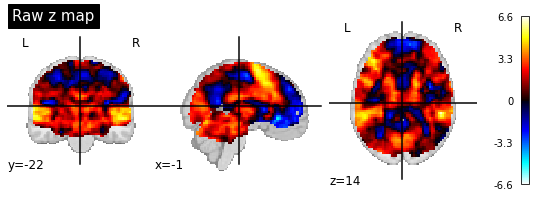

In [6]:
from nilearn import plotting
# choose cut_coords for consistent visualization
cut_coords = [-1, -22, 14]
display = plotting.plot_stat_map(z_map, title='Raw z map', cut_coords=cut_coords)

## Startistical thresholding
### FPR control
Now, we can consider different error-controling schemes to obtain statistically valid thresholds. The first one is simply to control the false positive rate (fpr), i.e. the rate of detections among the null hypotheses.

alpha=0.001 corresponds to a z-scale threshold of 3.29


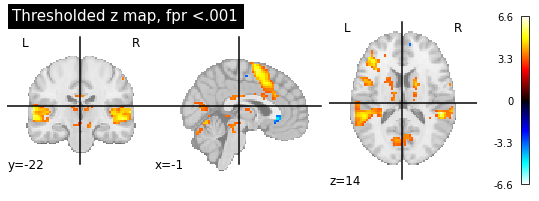

In [7]:
from nilearn.glm import threshold_stats_img
thresholded_map1, threshold1 = threshold_stats_img(
    z_map,
    alpha=.001,
    height_control='fpr',
    two_sided=True,
)
print('alpha=0.001 corresponds to a z-scale threshold of %.3g' %threshold1)
plotting.plot_stat_map(thresholded_map1, title='Thresholded z map, fpr <.001',
    cut_coords=cut_coords)

To have a less noisy image, we can remove all connected components with less than 10 voxels

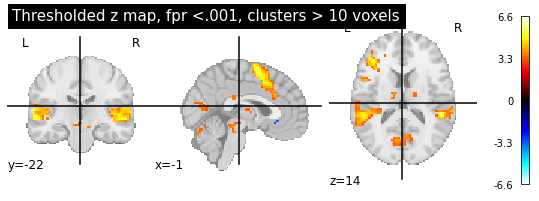

In [8]:
from nilearn.glm import threshold_stats_img
thresholded_map_, _ = threshold_stats_img(
    z_map,
    alpha=.001,
    height_control='fpr',
    cluster_threshold=10,
    two_sided=True,
)
plotting.plot_stat_map(thresholded_map_, title='Thresholded z map, fpr <.001, clusters > 10 voxels',
    cut_coords=cut_coords
)

### FDR control
Alternatively, one can controle the False discovery rate (FDR),  i.e. the expected value of the ratio of false detections among detections. For instance, let us impose FDR <.05.

The FDR=.05 threshold is 2.37


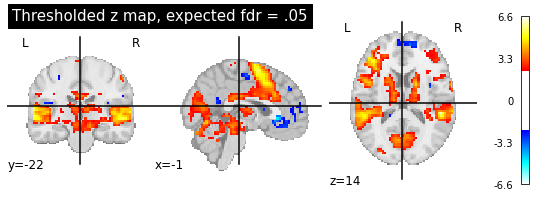

In [9]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=.05, height_control='fdr')
print('The FDR=.05 threshold is %.3g' % threshold2)
plotting.plot_stat_map(thresholded_map2, cut_coords=cut_coords,
                       title='Thresholded z map, expected fdr = .05',
                       threshold=threshold2)

Since there are quite a lot of voxels with high values, this leads to a low threshold, hence a lot of detections. **In expectation** 5% of these detections are false.

#### FWER Control
To get a more reliable result, we could instead use FWER <.05 (Family-Wise Error Rate control) and no cluster-level threshold.
The FWER is the probbaility of making one single false detection. This is simply done by applying Bonferroni correction: we control the false positive rate of (say) 0.05/(# tested voxels).

The p<.05 Bonferroni-corrected threshold is 4.88


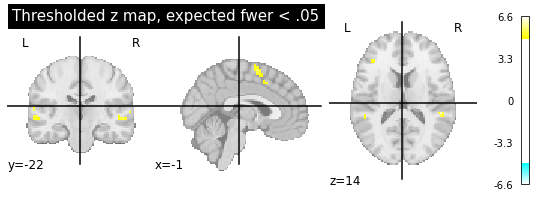

In [10]:
thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=.05, height_control='bonferroni')
print('The p<.05 Bonferroni-corrected threshold is %.3g' % threshold3)
plotting.plot_stat_map(thresholded_map3, cut_coords=cut_coords,
                       title='Thresholded z map, expected fwer < .05',
                       threshold=threshold3)

These different thresholds correspond to different statistical
guarantees: in the FWER-corrected image there is only a
probability smaller than .05 of observing any false positive voxel. In the
FDR-corrected image, 5% of the voxels found are likely to be false
positives. In the uncorrected image, one expects a few tens of false
positive voxels.



## Non-parametric inference
Bonferroni-based error control is in general a bit conservative (it is tight only for structly independent tests). We can use a tighter test by applying non-parametric inference: we construct a null hypothesis distribution by sampling surrogate variables (here, for a one-sample test, this is simply a random sign flipping of the input data). Then we can compare the actual map values to this non-parametric null distribution. For FWER control, we compare them to the dustribution of the max ofthe map under *n_perm* random sign flips.

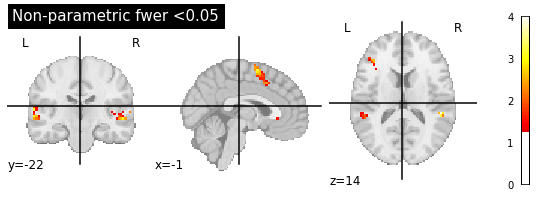

In [11]:
import numpy as np
from nilearn.mass_univariate import permuted_ols
from nilearn.glm.second_level import non_parametric_inference

pvals_img = non_parametric_inference(
    cmap_filenames, design_matrix=design_matrix, n_perm=10000, model_intercept=False,
    two_sided_test=True)
plotting.plot_stat_map(pvals_img, threshold=-np.log10(.05), cut_coords=cut_coords, title='Non-parametric fwer <0.05')

We gain a bit of sensitivity wrt Bonferroni (not much actually). Note that the API is a bit different, what is returned are (corrected) log1Op-values, not z-scale values. Hence the different threshold.

## Can we trust the regions that we obtain ?
Especially, when a low threshold is used, one may wonder whether whether the regions really outline true positives or not. To gain information, we estimate the true discovery proportion, TDP=1-FDP, for all regions obtained.

In [12]:
from nilearn.glm import cluster_level_inference
proportion_true_discoveries_img = cluster_level_inference(
    z_map, threshold=[threshold2], alpha=.05)

This function estimates the proportion of true positive in each connected component of the regions obtained by threhsolding the map with threshold2. Note that there is one huge cluster in the present case.

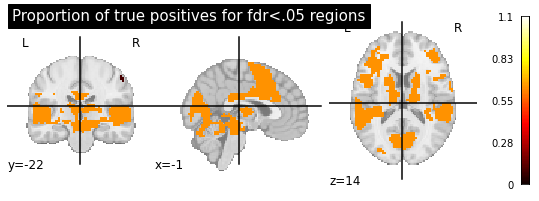

In [13]:
plotting.plot_stat_map(
    proportion_true_discoveries_img, threshold=0.,
    cut_coords=cut_coords, vmax=1.1, colorbar=True,
    title='Proportion of true positives for fdr<.05 regions')

In [14]:
np.unique(proportion_true_discoveries_img.get_fdata())

array([0.        , 0.09884467, 0.64135714])

Note the discrepancy between "fdr <= 0.05" and "fdp < 0.35 with probability 95%" !
Now let's redo is with threhsold1, that was a bit more stringent.

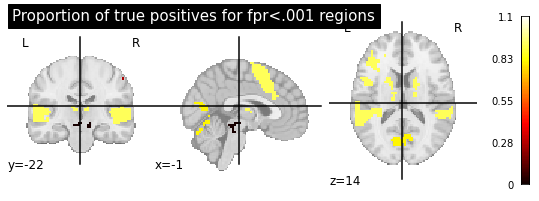

In [15]:
from nilearn.glm import cluster_level_inference
proportion_true_discoveries_img = cluster_level_inference(
    z_map, threshold=[threshold1], alpha=.05)

plotting.plot_stat_map(
    proportion_true_discoveries_img, threshold=0.,
    cut_coords=cut_coords, vmax=1.1, colorbar=True,
    title='Proportion of true positives for fpr<.001 regions')

We obtain smaller regions with higher tdp.
Now we can consider regions obtained using fwer-controling threshold:

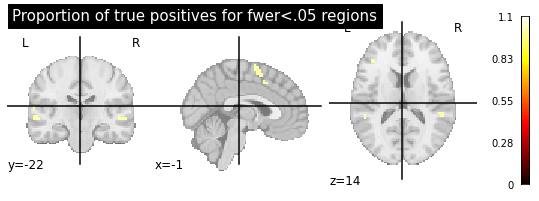

In [16]:
from nilearn.glm import cluster_level_inference
proportion_true_discoveries_img = cluster_level_inference(
    z_map, threshold=[threshold3], alpha=.05)

plotting.plot_stat_map(
    proportion_true_discoveries_img, threshold=0.,
    cut_coords=cut_coords, vmax=1.1, colorbar=True,
    title='Proportion of true positives for fwer<.05 regions')

Without suprise, given the very high thresholds, regions are small but we can be very confident that they only contain true positives (TDP=1 in all clusters).

## Excercise: redo the whole sequence on another dataset, 
eg https://github.com/nilearn/nilearn/blob/main/examples/05_glm_second_level/plot_second_level_association_test.py